# Semi-Supervised Classification with Graph Convolutional Networks
### Thomas Kipf & Max Welling (ICLR 2017)
**Leonardo Lavagna**  
**09/07/25**

In [ ]:
###

## Motivation & Problem Statement

**Goal:** Predict node classes in a graph using limited labeled data.

- Graph = structured domain (e.g., citation, social, biological)
- Each node: feature vector  
- Edges: encode relationships

**Challenge:**

- Traditional ML assumes regular input (grids, sequences)
- Graphs are irregular: variable degree, no canonical order

*Example:* Classify papers in a citation graph with only 5% labeled.


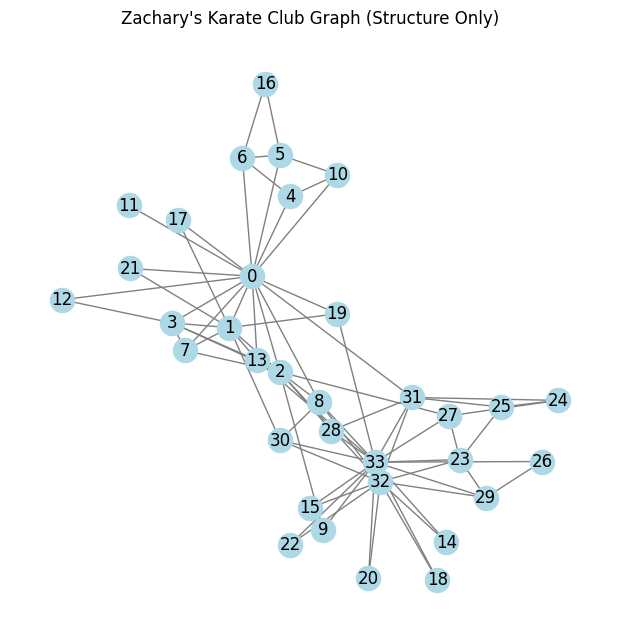

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.karate_club_graph()

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Zachary's Karate Club Graph (Structure Only)")
plt.show()


## What GCNs Solve

GCNs extend neural networks to graphs.

**Why MLPs fail:** Ignore edges (structure)  
**Why label propagation fails:** Relies only on topology; lacks learnable transformation

GCNs combine:
- Node features (like MLPs)
- Graph structure (like LP)
- Learn how to propagate and transform features over graph topology.


In [8]:
import numpy as np

# Adjacency matrix and node features
A = nx.to_numpy_array(G)
# One-hot encoding for features
X = np.eye(len(G))

print("Adjacency shape:", A.shape)
print("Feature matrix shape:", X.shape)

Adjacency shape: (34, 34)
Feature matrix shape: (34, 34)


## Spectral Graph Convolutions

**Graph Fourier Transform:**

$$ L = I - D^{-1/2} A D^{-1/2} $$  
with eigenbasis  
$$ L = U \Lambda U^\top $$

**Convolution on a graph:**

$$ g_\theta * x = U g_\theta(\Lambda) U^\top x $$

**Why this works:**
- $U^\top x$: Graph Fourier transform
- $g_\theta(\Lambda)$: Learnable spectral filter

Problem: Computing $U$ is expensive $O(N^3)$


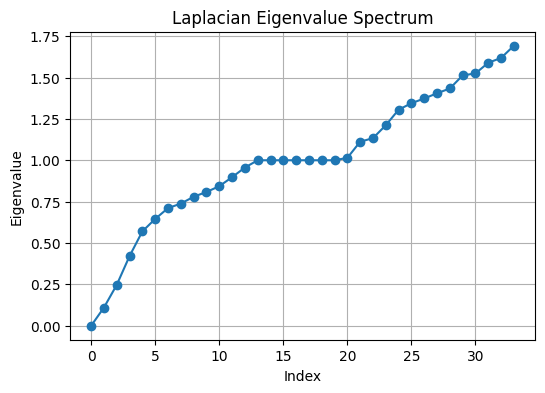

In [9]:
from scipy.linalg import eigh
import numpy as np

A = nx.to_numpy_array(G)
D = np.diag(A.sum(axis=1))
L = np.eye(len(G)) - np.linalg.inv(np.sqrt(D)) @ A @ np.linalg.inv(np.sqrt(D))

eigvals, eigvecs = eigh(L)

plt.figure(figsize=(6, 4))
plt.plot(eigvals, marker='o')
plt.title("Laplacian Eigenvalue Spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()


## Chebyshev Polynomial Approximation

To avoid costly eigendecomposition:

$$ g_\theta * x \approx \sum_{k=0}^K \theta_k T_k(\tilde{L}) x $$

Where:

- $T_k$: Chebyshev polynomial of degree $k$
- $\tilde{L} = \frac{2}{\lambda_{\max}} L - I$

**Advantages:**
- Localized filters ($K$-hop neighborhood)
- Efficient computation: $O(K|E|)

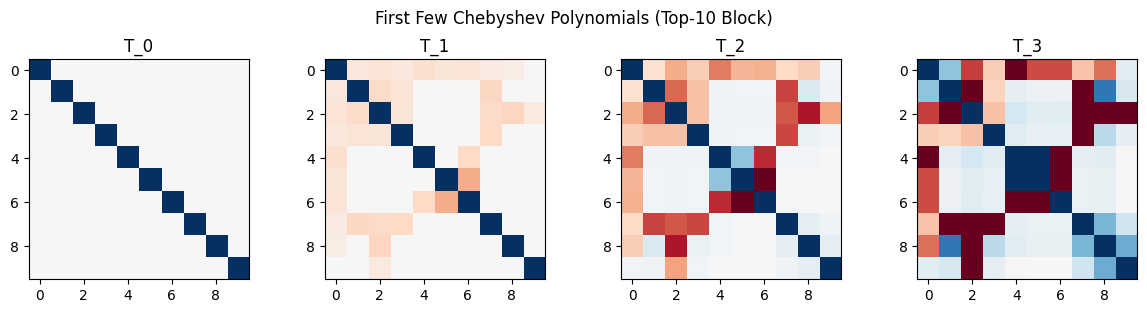

In [10]:
# Compute Chebyshev polynomials T_0 to T_3
T_k = [np.eye(L.shape[0]), L]
for k in range(2, 4):
    T_k.append(2 * L @ T_k[-1] - T_k[-2])

plt.figure(figsize=(12, 3))
for i, Tk in enumerate(T_k):
    plt.subplot(1, 4, i+1)
    plt.imshow(Tk[:10, :10], cmap="RdBu", vmin=-1, vmax=1)
    plt.title(f"T_{i}")
plt.suptitle("First Few Chebyshev Polynomials (Top-10 Block)")
plt.tight_layout()
plt.show()

## First-Order Approximation & GCN Layer

Set $K = 1$, we get:

$$ g_\theta * x \approx \theta (I + D^{-1/2} A D^{-1/2}) x $$

Numerical instability: eigenvalues up to 2 → gradient explosion

**Fix: Renormalization trick**

$$ \tilde{A} = A + I $$
$$ \hat{A} = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} $$

**GCN Layer**:

$$ H^{(l+1)} = \sigma(\hat{A} H^{(l)} W^{(l)}) $$


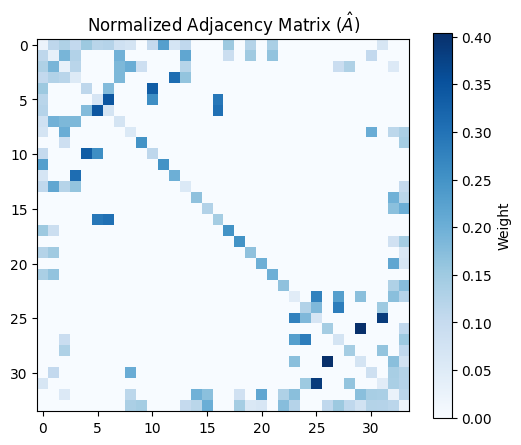

In [11]:
I = np.eye(A.shape[0])
A_tilde = A + I
D_tilde = np.diag(np.sum(A_tilde, axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D_tilde))
A_hat = D_inv_sqrt @ A_tilde @ D_inv_sqrt

plt.figure(figsize=(6, 5))
plt.imshow(A_hat, cmap="Blues")
plt.colorbar(label="Weight")
plt.title("Normalized Adjacency Matrix ($\\hat{A}$)")
plt.show()


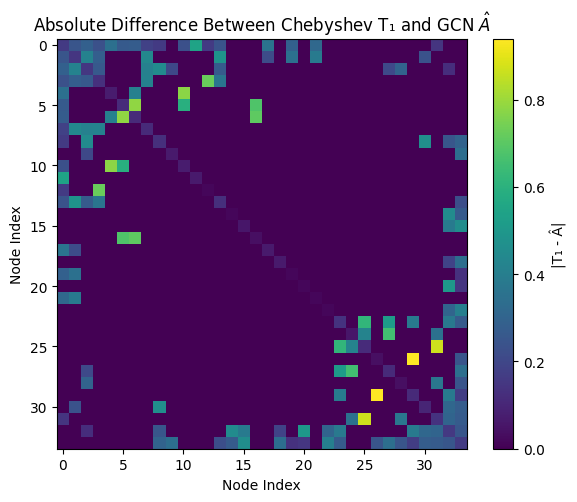

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

# Load graph and compute adjacency
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)

# Compute normalized Laplacian L
D = np.diag(A.sum(axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D))
L = np.eye(len(G)) - D_inv_sqrt @ A @ D_inv_sqrt

# Chebyshev approximation: scale Laplacian to [-1, 1]
lambda_max = np.linalg.eigvalsh(L).max()
L_cheb = (2 / lambda_max) * L - np.eye(len(G))
T1 = L_cheb

# GCN renormalization trick
I = np.eye(A.shape[0])
A_tilde = A + I
D_tilde = np.diag(np.sum(A_tilde, axis=1))
D_inv_sqrt_tilde = np.linalg.inv(np.sqrt(D_tilde))
A_hat = D_inv_sqrt_tilde @ A_tilde @ D_inv_sqrt_tilde

# Comparison
diff = T1 - A_hat
abs_diff = np.abs(diff)

# Plot difference heatmap
plt.figure(figsize=(6, 5))
plt.imshow(abs_diff, cmap='viridis')
plt.colorbar(label='|T₁ - Â|')
plt.title("Absolute Difference Between Chebyshev T₁ and GCN $\\hat{A}$")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.tight_layout()
plt.show()


## Full GCN Forward Pass

**Two-layer GCN:**

$$ Z = \text{softmax}(\hat{A} \cdot \text{ReLU}(\hat{A} X W^{(0)}) W^{(1)}) $$

- $W^{(0)}$: input → hidden
- $W^{(1)}$: hidden → output
- $\hat{A}$: normalized adjacency with self-loops

Each layer:  
**Aggregate → Transform → Nonlinear Activation**


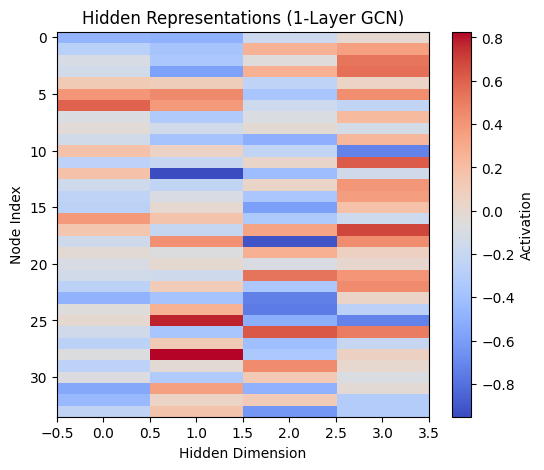

In [13]:
np.random.seed(42)
W = np.random.randn(X.shape[1], 4)
H = A_hat @ X @ W
plt.figure(figsize=(6, 5))
plt.imshow(H, aspect='auto', cmap='coolwarm')
plt.colorbar(label="Activation")
plt.title("Hidden Representations (1-Layer GCN)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Node Index")
plt.show()

## Why GCNs Work (Graph Signal Processing View)

### Graph as signal domain:
- Each feature dimension is a signal over the graph

### GCNs ≈ trainable low-pass filters:
- Smooth features across edges (homophily)
- Suppress noise, preserve global structure

### GCN = message passing + transformation:
- $\hat{A}$: Aggregation (graph filtering)
- $W^{(l)}$: Learnable transformation

Stacking layers:
- Expands receptive field ($k$-hop)
- Builds hierarchical representations


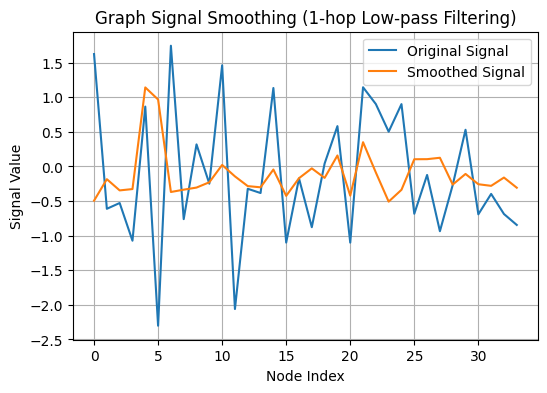

In [14]:
np.random.seed(1)
signal = np.random.randn(len(G))
smoothed_signal = A_hat @ signal

plt.figure(figsize=(6, 4))
plt.plot(signal, label="Original Signal")
plt.plot(smoothed_signal, label="Smoothed Signal")
plt.legend()
plt.title("Graph Signal Smoothing (1-hop Low-pass Filtering)")
plt.xlabel("Node Index")
plt.ylabel("Signal Value")
plt.grid(True)
plt.show()


## GCN and Weisfeiler-Lehman Test

### Weisfeiler-Lehman (WL) Test:
$$ h_i^{(l+1)} = \text{hash}(h_i^{(l)}, \{ h_j^{(l)} : j \in \mathcal{N}(i) \}) $$

### GCN Analogy:
$$ h_i^{(l+1)} = \sigma\left( \sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{d_i d_j}} h_j^{(l)} W^{(l)} \right) $$

**Why this matters:**
- Aggregates and transforms neighborhood info
- Differentiable, trainable generalization of WL
- Strong theoretical foundation for expressiveness


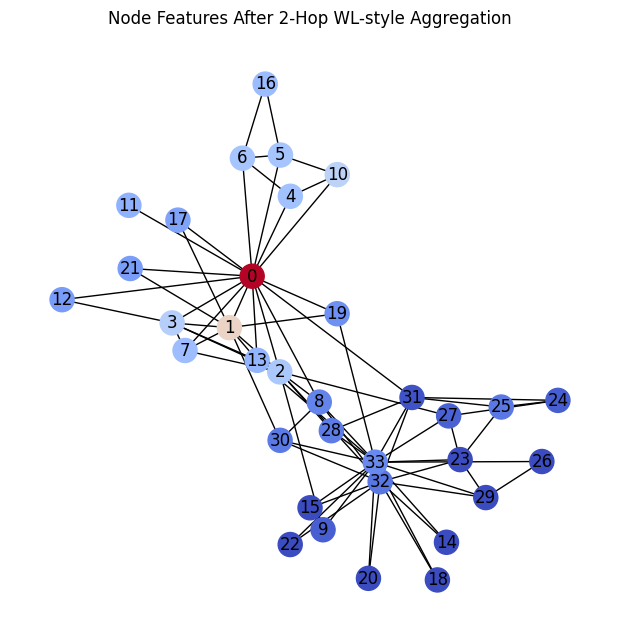

In [16]:
H0 = X.copy()
H1 = A_hat @ H0
H2 = A_hat @ H1

# Visualize node color by feature value (just one dimension)
colors = H2[:, 0]

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color=colors, cmap='coolwarm')
plt.title("Node Features After 2-Hop WL-style Aggregation")
#plt.colorbar(label="Feature 0 Value")
plt.show()


## Node Classification Results

**Datasets:** Cora, Citeseer, Pubmed

| Model     | Cora | Citeseer | Pubmed |
|-----------|------|----------|--------|
| MLP       | 55.1 | 46.5     | 71.4   |
| Planetoid | 75.7 | 64.7     | 77.2   |
| **GCN**   | **81.5** | **70.3** | **79.0** |

Combines structure and features  
Outperforms static embeddings like DeepWalk


/tmp/ipython-input-17-2639227423.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("coolwarm")


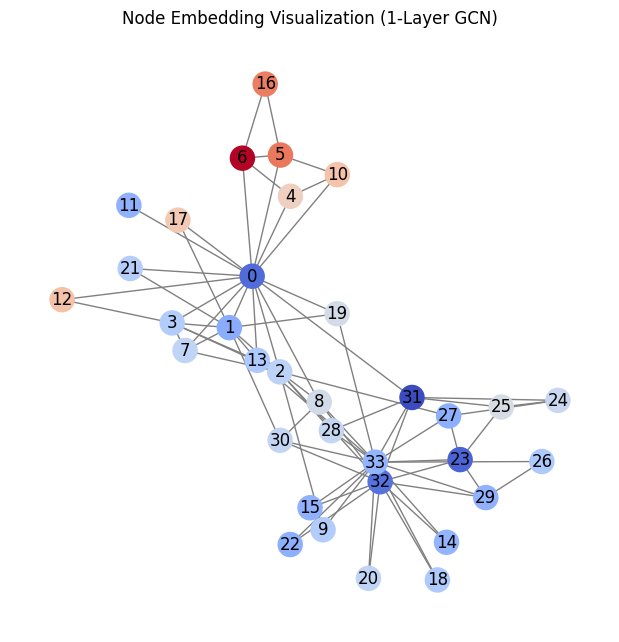

In [17]:
from matplotlib.cm import get_cmap

embedding = H[:, 0]
cmap = get_cmap("coolwarm")
colors = cmap((embedding - embedding.min()) / (embedding.max() - embedding.min()))

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color='gray')
plt.title("Node Embedding Visualization (1-Layer GCN)")
plt.show()


## t-SNE Visualization

- 2-layer GCN trained on Cora
- Only 5% of nodes labeled
- Output embeddings visualized with t-SNE

Clear class-based clusters emerge.

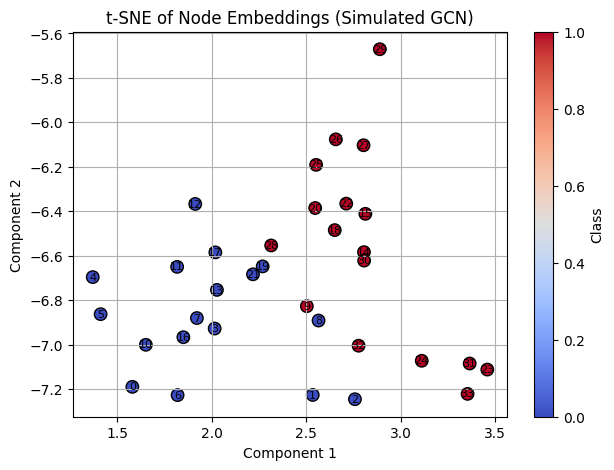

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Load graph and create features
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)
X = np.eye(len(G))

# GCN preprocessing: compute normalized adjacency
I = np.eye(A.shape[0])
A_tilde = A + I
D_tilde = np.diag(np.sum(A_tilde, axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D_tilde))
A_hat = D_inv_sqrt @ A_tilde @ D_inv_sqrt

# Simulate 2-layer GCN embeddings (random weights)
np.random.seed(42)
W0 = np.random.randn(X.shape[1], 16)
W1 = np.random.randn(16, 4)

H1 = A_hat @ X @ W0
H1 = np.maximum(H1, 0)  # ReLU
H2 = A_hat @ H1 @ W1  #

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=123)
Z_2d = tsne.fit_transform(H2)

# Extract labels from club names
labels = [G.nodes[i]['club'] for i in G.nodes()]
le = LabelEncoder()
y = le.fit_transform(labels)

# Plot
plt.figure(figsize=(7, 5))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=80)
for i, label in enumerate(G.nodes()):
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(label), fontsize=8, ha='center', va='center')
plt.title("t-SNE of Node Embeddings (Simulated GCN)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Class")
plt.grid(True)
plt.show()


## Training Time & Scalability

**GCN runtime per layer:**

- $(|E|CF)$ due to sparse matrix ops
- Trains in seconds on GPU

**Comparison:**
- GCN (Cora): ~4s
- Planetoid: ~13s
- DeepWalk: much slower

(Insert Figure 2: training time vs. # edges)


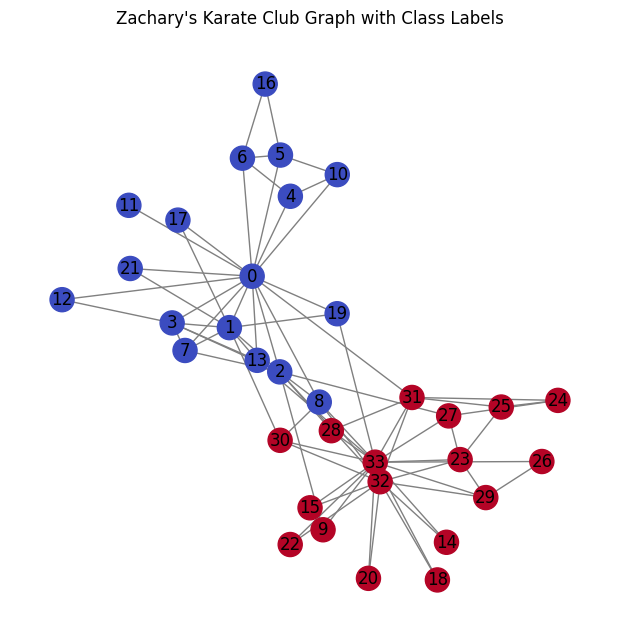

GCN (untrained) Accuracy: 0.50


In [21]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Step 1: Load the graph and create features/labels
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)
X = np.eye(A.shape[0])

# Extract labels and encode to integers
labels = [G.nodes[i]['club'] for i in G.nodes()]
le = LabelEncoder()
y = le.fit_transform(labels)  # 'Mr. Hi' = 0, 'Officer' = 1

# Visualize original graph with class labels
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(6, 6))
nx.draw(G, pos, node_color=y, cmap='coolwarm', with_labels=True, edge_color='gray')
plt.title("Zachary's Karate Club Graph with Class Labels")
plt.show()

# Step 2: Normalize the adjacency matrix (GCN renormalization trick)
I = np.eye(A.shape[0])
A_tilde = A + I
D_tilde = np.diag(np.sum(A_tilde, axis=1))
D_inv_sqrt = np.linalg.inv(np.sqrt(D_tilde))
A_hat = D_inv_sqrt @ A_tilde @ D_inv_sqrt

# Step 3: Simulate a 2-layer GCN (random weights)
np.random.seed(42)
W0 = np.random.randn(X.shape[1], 16)  # Input -> Hidden
W1 = np.random.randn(16, 2)           # Hidden -> Output

H1 = A_hat @ X @ W0
H1 = np.maximum(H1, 0)  # ReLU
H2 = A_hat @ H1 @ W1    # Logits for 2 classes

# Step 4: Predict class and compute accuracy
y_pred = np.argmax(H2, axis=1)
acc = accuracy_score(y, y_pred)
print(f"GCN (untrained) Accuracy: {acc:.2f}")


## Conclusion

✅ GCNs efficiently extend CNNs to graphs  
✅ Grounded in spectral graph theory  
✅ Learn to smooth and transform features via structure  
✅ Strong performance with few labels  
✅ Foundation of many modern GNNs


Epoch 000 | Loss: 0.6968 | Accuracy: 0.5000
Epoch 020 | Loss: 0.4485 | Accuracy: 0.9706
Epoch 040 | Loss: 0.1516 | Accuracy: 0.9706
Epoch 060 | Loss: 0.0796 | Accuracy: 0.9706
Epoch 080 | Loss: 0.0561 | Accuracy: 0.9706
Epoch 100 | Loss: 0.0419 | Accuracy: 1.0000
Epoch 120 | Loss: 0.0323 | Accuracy: 1.0000
Epoch 140 | Loss: 0.0256 | Accuracy: 1.0000
Epoch 160 | Loss: 0.0207 | Accuracy: 1.0000
Epoch 180 | Loss: 0.0169 | Accuracy: 1.0000
Epoch 199 | Loss: 0.0141 | Accuracy: 1.0000


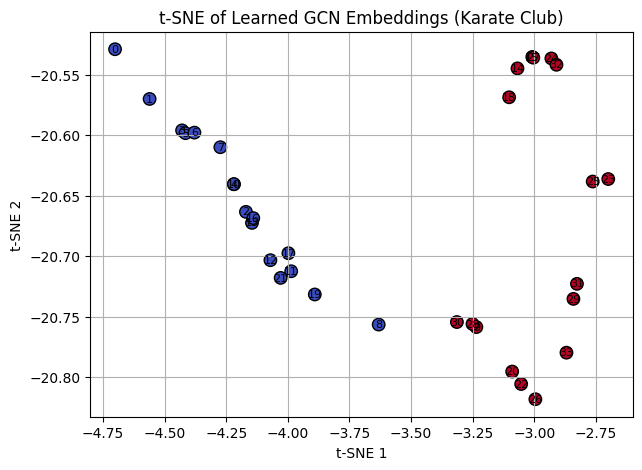

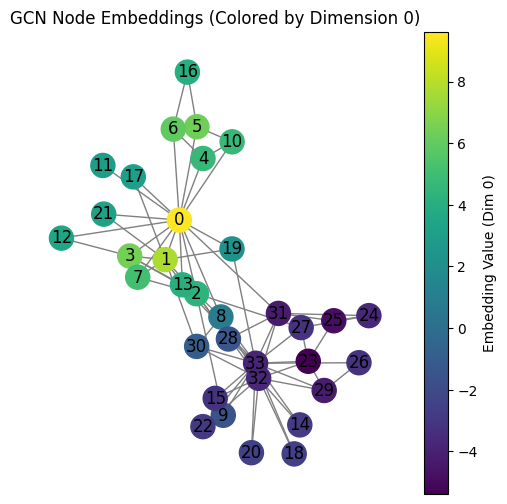

In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility: Normalize adjacency matrix
def normalize_adjacency(A):
    I = np.eye(A.shape[0])
    A_tilde = A + I
    D_tilde = np.diag(np.sum(A_tilde, axis=1))
    D_inv_sqrt = np.linalg.inv(np.sqrt(D_tilde))
    return D_inv_sqrt @ A_tilde @ D_inv_sqrt

# Utility: t-SNE visualization
def plot_tsne(embeddings, labels, title="t-SNE of Embeddings"):
    Z = TSNE(n_components=2, random_state=0).fit_transform(embeddings)
    plt.figure(figsize=(7, 5))
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap='coolwarm', s=80, edgecolors='k')
    for i in range(len(Z)):
        plt.text(Z[i, 0], Z[i, 1], str(i), fontsize=8, ha='center', va='center')
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()

# 🧠 GCN Model
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(in_dim, hidden_dim)
        self.gc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, adj):
        x = adj @ x
        x = self.gc1(x)
        x = F.relu(x)
        x = adj @ x
        x = self.gc2(x)
        return x

# Load Karate Club graph
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)

# One-hot node features
X = np.eye(len(G), dtype=np.float32)

# Node labels (Mr. Hi = 0, Officer = 1)
labels = [G.nodes[i]['club'] for i in G.nodes()]
le = LabelEncoder()
y = le.fit_transform(labels)

# Preprocessing
A_hat = normalize_adjacency(A)
X_tensor = torch.tensor(X, dtype=torch.float32)
A_tensor = torch.tensor(A_hat, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# GCN model and optimizer
model = GCN(in_dim=X.shape[1], hidden_dim=16, out_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    logits = model(X_tensor, A_tensor)
    loss = loss_fn(logits, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == epochs - 1:
        preds = logits.argmax(dim=1)
        acc = (preds == y_tensor).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_tensor, A_tensor)
    embeddings = logits.numpy()

# t-SNE of final embeddings
plot_tsne(embeddings, y, title="t-SNE of Learned GCN Embeddings (Karate Club)")

# Graph visualization with embedding dim 0
pos = nx.spring_layout(G, seed=42)
dim0 = embeddings[:, 0]
normed = (dim0 - dim0.min()) / (dim0.max() - dim0.min())
colors = cm.viridis(normed)

plt.figure(figsize=(6, 6))
ax = plt.gca()  # Get current axes

nodes = nx.draw(G, pos, node_color=colors, edge_color='gray', with_labels=True, ax=ax)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=dim0.min(), vmax=dim0.max()))
sm.set_array([])  # Required for ScalarMappable without an image
plt.colorbar(sm, ax=ax, label="Embedding Value (Dim 0)")
plt.title("GCN Node Embeddings (Colored by Dimension 0)")
plt.show()

## Thank You


_Paper: Kipf & Welling, ICLR 2017_  
📎 [https://tkipf.github.io/graph-convolutional-networks](https://tkipf.github.io/graph-convolutional-networks)


In [19]:
###